# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed.



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_groq langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [3]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatGroq(model="openai/gpt-oss-120b")
llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it.

 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

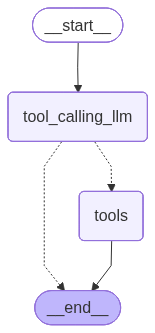

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_732d558c-9640-49a1-bf3a-8e8634e456e1)
 Call ID: fc_732d558c-9640-49a1-bf3a-8e8634e456e1
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


*This is the visualization on Langgraph Studio:*

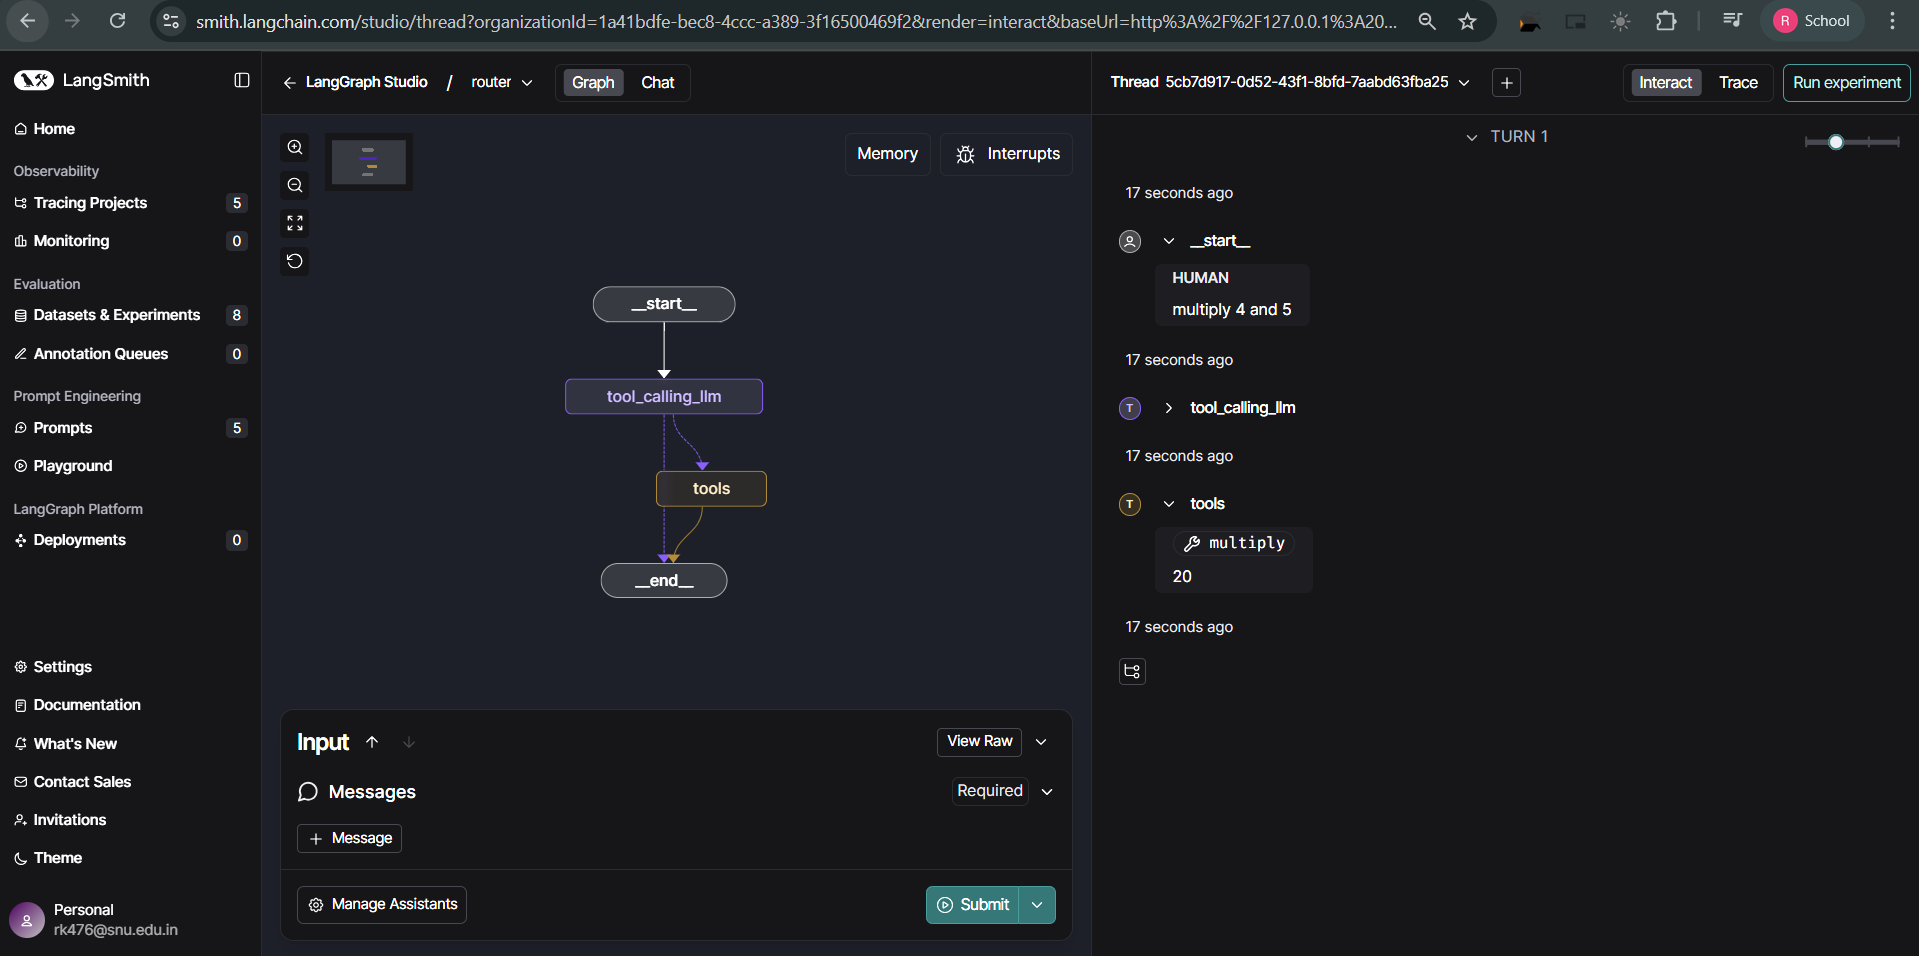

Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`.

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.
Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.

# MY EXAMPLES:

In [22]:
import datetime
import random
from langchain_core.tools import tool

@tool
def get_current_time() -> str:
    """Returns the current time."""
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d %H:%M:%S")

@tool
def generate_random_number(min_val: int, max_val: int) -> int:
    """Generates a random integer between min_val and max_val (inclusive)."""
    return random.randint(min_val, max_val)

tools = [multiply, get_current_time, generate_random_number]

llm_with_tools = llm.bind_tools(tools)

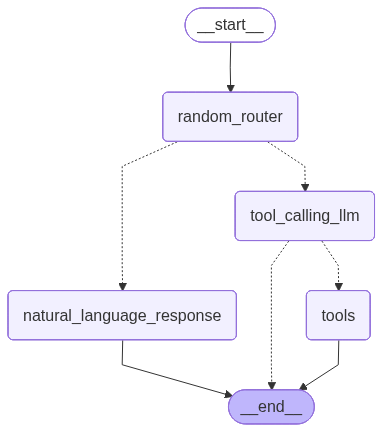

In [23]:
import random
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import HumanMessage

# Define a node that randomly decides whether to call a tool or respond directly
def random_router(state: MessagesState):
    if random.random() > 0.5:  # 50% chance to call a tool
        print("Routing to tool_calling_llm")
        return {"next": "tool_calling_llm"} # Return a dictionary with the next node name
    else:
        print("Routing to natural_language_response")
        return {"next": "natural_language_response"} # Return a dictionary with the next node name

# Node for natural language response
def natural_language_response(state: MessagesState):
    # In a real scenario, you would use the LLM to generate a response here
    print("Generating natural language response")
    return {"messages": [HumanMessage(content="This is a natural language response.")]}

# Node
def tool_calling_llm(state: MessagesState):
    print("Calling LLM for tool call")
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("random_router", random_router)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools)) # Use the tools defined in the previous step
builder.add_node("natural_language_response", natural_language_response)


builder.add_edge(START, "random_router")

# Add conditional edges from the random_router
builder.add_conditional_edges(
    "random_router",
    lambda x: x["next"], # Access the next node name from the dictionary
    {
        "tool_calling_llm": "tool_calling_llm",
        "natural_language_response": "natural_language_response",
    }
)

# Add edges from the tool_calling_llm
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition, # Use the built-in tools_condition to check for tool calls
)

# Add edges from the other nodes to END
builder.add_edge("tools", END)
builder.add_edge("natural_language_response", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
from langchain_core.messages import HumanMessage

# Test the graph with different examples
test_cases = [
    "What is the current time?",
    "Generate a random number between 1 and 100.",
    "Tell me a joke.", # This should likely trigger a natural language response
    "What is 5 multiplied by 7?", # This might trigger the multiply tool if it were still bound
    "How are you today?" # This should likely trigger a natural language response
]

for i, test_case in enumerate(test_cases):
    print(f"\n--- Test Case {i+1}: {test_case} ---")
    messages = [HumanMessage(content=test_case)]
    result = graph.invoke({"messages": messages})
    for m in result['messages']:
        m.pretty_print()


--- Test Case 1: What is the current time? ---
Routing to tool_calling_llm
Calling LLM for tool call
================================ Human Message =================================

What is the current time?
================================== Ai Message ==================================
Tool Calls:
  get_current_time (fc_b680c411-2f95-41b5-ac8c-16497e78652a)
 Call ID: fc_b680c411-2f95-41b5-ac8c-16497e78652a
  Args:
================================= Tool Message =================================
Name: get_current_time

2025-10-14 16:11:26

--- Test Case 2: Generate a random number between 1 and 100. ---
Routing to tool_calling_llm
Calling LLM for tool call
================================ Human Message =================================

Generate a random number between 1 and 100.
================================== Ai Message ==================================
Tool Calls:
  generate_random_number (fc_b071dc07-4068-49e1-aa47-4a44fd2d0f16)
 Call ID: fc_b071dc07-4068-49e1-aa47-4a44fd2d0f

*Outputs of multiple HumanMessages of this LangGraph:*

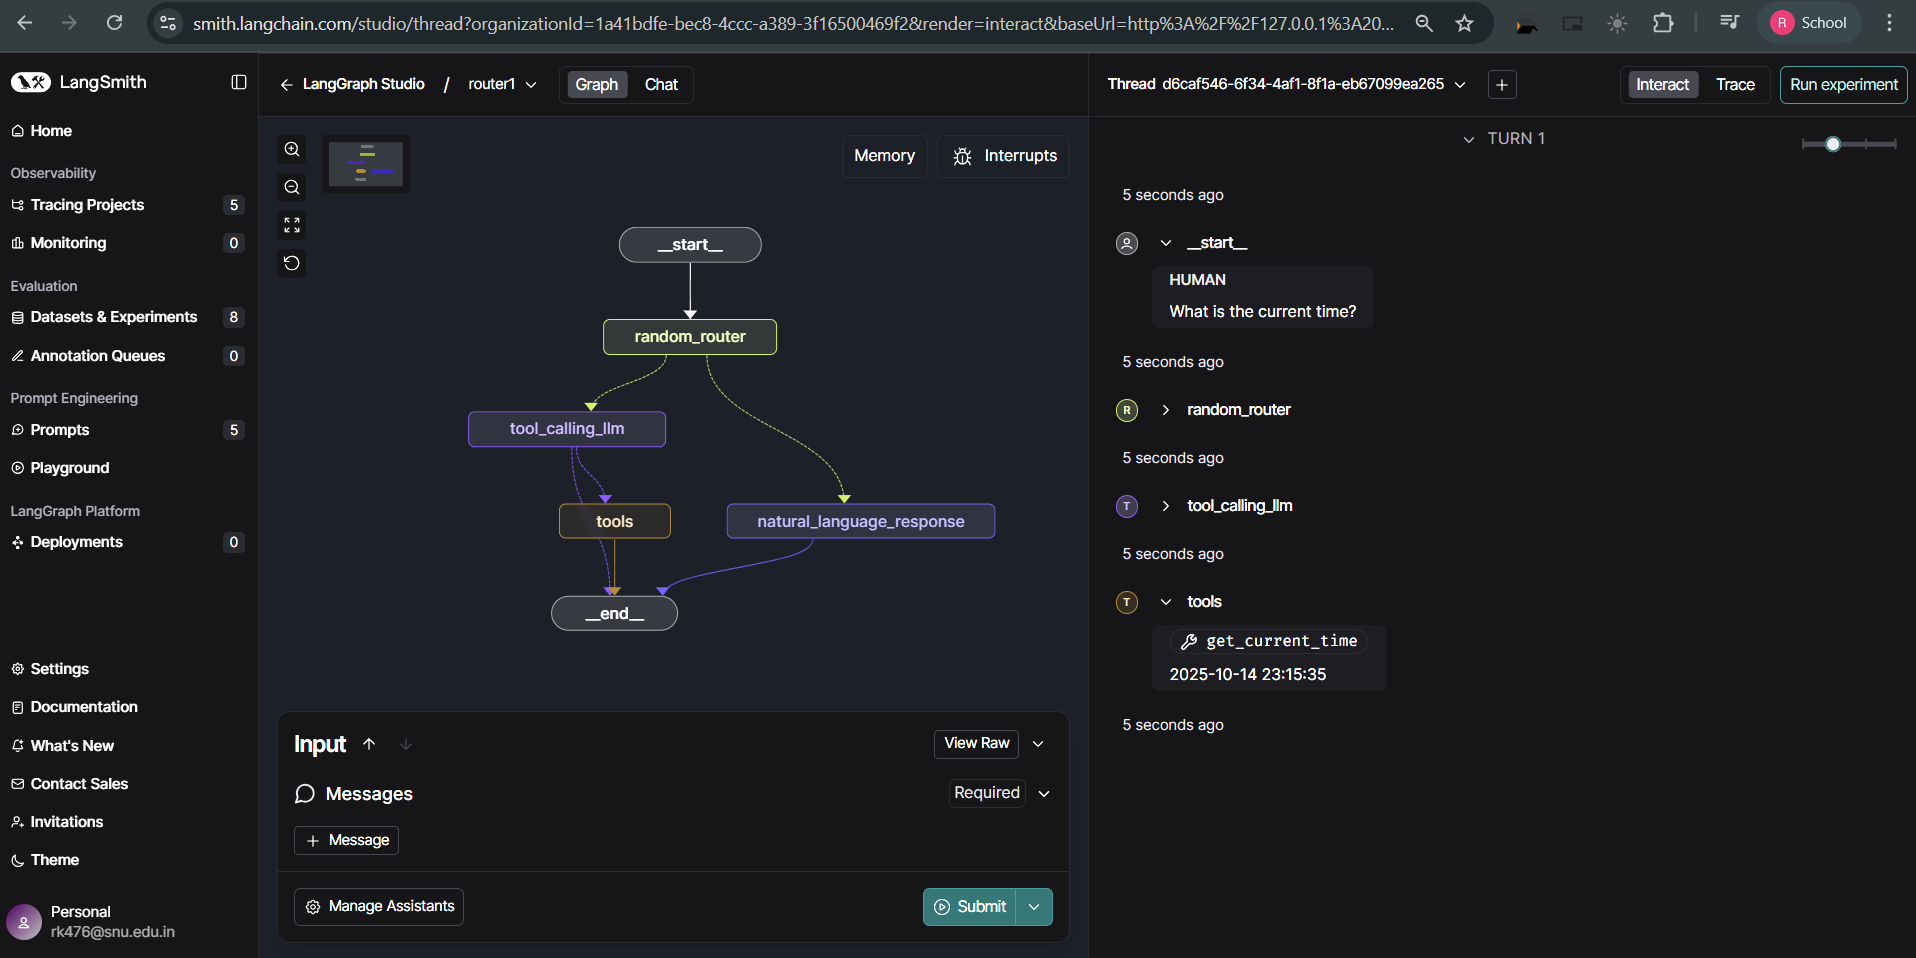

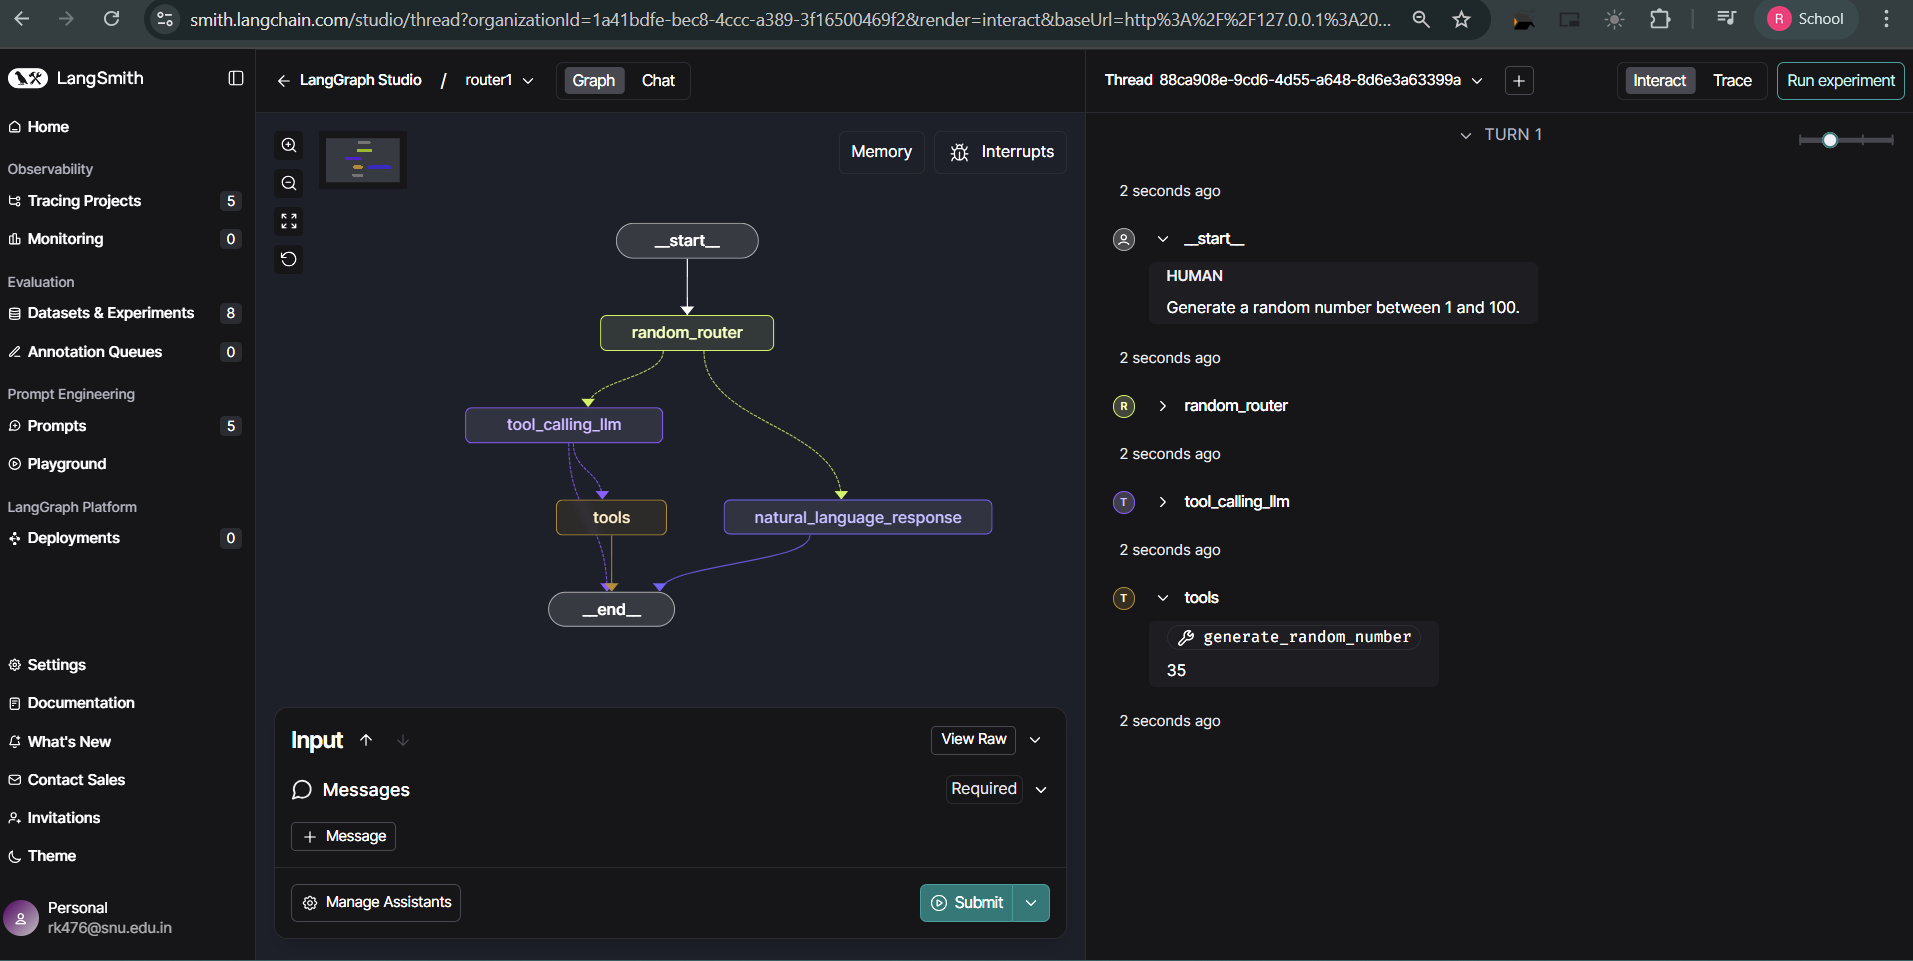